In [1]:
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
from matplotlib import pyplot as plt

In [3]:
from lamarck.assistant import GenomeCreator
from lamarck.assistant import PopulationCreator
from lamarck import Environment

In [4]:
from salesman import TravelSalesman

# Setup

#### Process

In [5]:
def process_deco(trav_salesman):
    def wrapper(route):
        return {'dist': trav_salesman.get_route_distance(route)}
    return wrapper

In [6]:
n_cities = 10

In [7]:
trav_salesman = TravelSalesman(n_cities, seed=123)

<AxesSubplot:xlabel='x', ylabel='y'>

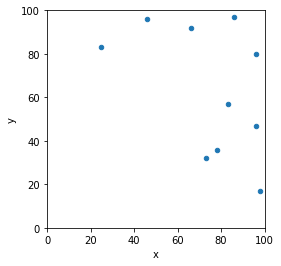

In [8]:
trav_salesman.plot()

# Finding best - Brute Force

In [9]:
gen = itertools.permutations((tuple(range(n_cities))), n_cities)
min_dist = np.inf
N = np.math.factorial(n_cities)
pbar = tqdm(range(N))
for _ in pbar:
    seq = next(gen)
    dist = trav_salesman.get_route_distance(seq)
    if dist < min_dist:
        min_dist = dist
        best_seq = seq

100%|██████████| 3628800/3628800 [01:43<00:00, 35077.87it/s]


(1, 5, 8, 4, 2, 9, 3, 0, 6, 7) dist: 184.9066830917233


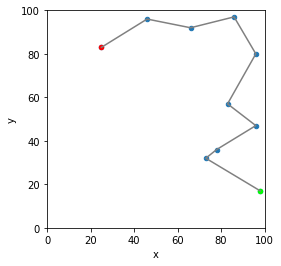

In [10]:
print(best_seq, 'dist:', min_dist)
trav_salesman.plot_route(best_seq)

# Finding best - GA

#### Optimization Function

In [9]:
process = process_deco(trav_salesman)

#### Genome Creation

In [10]:
genome_creator = GenomeCreator()

In [11]:
genome_creator.add_gene_specs.vectorial(name='route',
                                        length=n_cities,
                                        replace=False,
                                        domain=list(range(n_cities)))

genome_blueprint = genome_creator.get_genome_blueprint()

In [12]:
genome_blueprint

{'route': {'type': 'vectorial',
  'domain': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'ranges': {'length': 10, 'replace': False}}}

#### Population

In [13]:
nrand=5000

In [14]:
pop_creator = PopulationCreator(genome_blueprint)
pop = pop_creator.create.rand(nrand)
pop.define()
pop

Population with 4992 Creatures with genes route (vectorial).
        

### Simulate

In [15]:
output = 'dist'
objective = 'min'
n_generations = 100

In [16]:
# Environment
env = Environment()
env.config.set_multi(True)
env.config.set_process(process)

In [17]:
pbar = tqdm(range(n_generations))
for _ in pbar:
    pbar.set_description('Simulating...')
    env.simulate(pop)
    pbar.set_description('Applying Fitness...')
    pop.apply_fitness.single_objective(output, objective=objective)
    pbar.set_description('Selecting...')
    pop.select()
    pbar.set_description('Repopulating...')
    pop.reproduce.mutate(p=0.05)
    pop.reproduce.tournament(n_dispute=3)

Repopulating...: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]   


<AxesSubplot:xlabel='generation', ylabel='dist'>

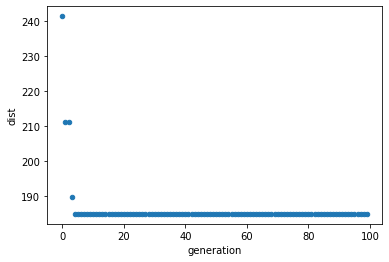

In [18]:
pop.plot.history('dist', min)

In [19]:
gen = 99

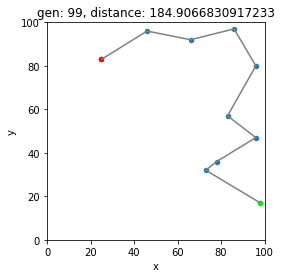

In [20]:
f = pop.datasets.history.generation == gen
df = pop.datasets.history[f]
seq = df.iloc[0]['route']
dist = df.iloc[0]['dist']
trav_salesman.plot_route(seq, title=f'gen: {gen}, distance: {dist}')
gen += 5

# For 20 cities

In [23]:
from lamarck import Optimizer

In [24]:
opt = Optimizer()
number_of_cities = 20
cities = tuple(range(number_of_cities))
opt.genome_creator.add_gene_specs.vectorial(name='route',
                                            length=number_of_cities,
                                            replace=False,
                                            domain=cities)

opt.create_population(n_rand=5000)
trav_salesman = TravelSalesman(number_of_cities, seed=123)
process = process_deco(trav_salesman)
opt.set_process(process)
opt.env.config.set_multi(True)
optpop = opt.run.single_objective(output='dist',
                                  objective='min',
                                  max_generations=100,
                                  p_mutation=0.1)

100%|██████████| 100/100 [23:59<00:00, 14.40s/it]


315.80575917508384

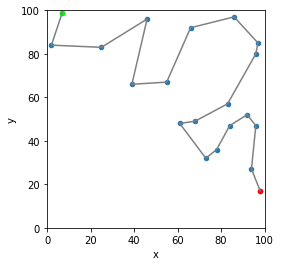

In [25]:
best_creature = optpop.get_creature.best()[0]
best_seq = best_creature.genome['route']
trav_salesman.plot_route(best_seq)
trav_salesman.get_route_distance(best_seq)

### Best I've found so far...

302.3768450963021

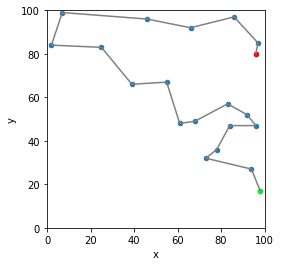

In [26]:
very_best_seq = (1, 19, 5, 8, 14, 4, 17, 2, 10, 15, 11, 13, 7, 12, 16, 6, 0, 3, 18, 9)
trav_salesman.plot_route(very_best_seq)
trav_salesman.get_route_distance(very_best_seq)